# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## 1. Introduction

### 1.1. Background
Izmir is the third largest city in Turkey with a population of around 4 million, the second biggest port after Istanbul, and a very good transport hub. It has total of 30 districts and 11 of them are counts as a central. The fact that almost half of its population of 4 million are under the age of 30, makes İzmir a city full of life. The city hosts tens of thousands of university students, educates scientists, artists, business leaders and academics. It is a rapidly growing city on the Central Aegean coast of Turkey. [1][2]

### 1.2. Problem description

In a highly populated city like Izmir, opening a restaurant is always more risky, costful and time consuming. Main goal of this project is, using KMeans clustering model and Foursquare locate which boroughs in Izmir suits well to opening a new restaurant in Izmir. This project will provide information about most common venues of boroughs and their characteristics. With that information stakeholders can choose which borough(s) suits well to them.

## 2. Data Description

### 2.1. Izmir

I found Turkey - Subnational Administrative Boundaries from HDX [3] the .xlsx the file has all neighborhoods, refugee camps, cities of Turkey and their latitude and longitude values in English and Turkish. I limit it to city of Izmir and cleaned data from unnecessary columns and created new csv file named "izmir_data" which includes borough name, latitude of borough, longitude of borough. Original file and cleaned file can be reachable from my github repo.

### 2.2. Nominatim

I used Nominatim from Geopy to get latitude and longitude value of Izmir.

* Geopy is a Python client for several popular geocoding web services. Geopy makes it easy for Python developers to locate the coordinates of addresses, cities, countries, and landmarks across the globe using third-party geocoders and other data sources. [4]

### 2.3. Foursquare API

I used Foursquare API to get the most common venues in boroughs of Izmir.

* The Places API offers real-time access to Foursquare’s global database of rich venue data and user content to power your location-based experiences in your app or website.[5]

## 3. Methodology

Importing necessary libraries.

In [2]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from sklearn.cluster import KMeans # import k-means from clustering stage
from sklearn.metrics import silhouette_score # Validation for elbow method


Creating dataframe from clean data.

In [3]:
df_izmir = pd.read_csv('izmir_data.csv')

First 5 rows of our data.

In [5]:
df_izmir.head()

,Borough,Latitude,Longitude
0,ALIAGA,38.802491,26.975580
1,BALCOVA,38.392353,27.048095
2,BAYINDIR,38.218886,27.648303
3,BAYRAKLI,38.467495,27.167934
4,BERGAMA,39.118371,27.173508


Dimension of data

In [104]:
df_izmir.shape

(30, 3)

Data types of rows

In [116]:
print('Data type of Borough:  ', type(df_izmir['Borough'][0]))
print('Data type of Latitude:  ', type(df_izmir['Latitude'][0]))
print('Data type of Longitude:  ', type(df_izmir['Longitude'][0]))

Data type of Borough:   <class 'str'>
Data type of Latitude:   <class 'numpy.float64'>
Data type of Longitude:   <class 'numpy.float64'>


Getting lattitude and longitude values of Izmir for map.

In [5]:
address = 'Izmir, TR'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Izmir are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Izmir are 38.4147331, 27.1434119.


I created map of Izmir using latitude and longitude values.

In [128]:
# create map of Izmir using latitude and longitude values
map_izmir = folium.Map(location=[latitude,longitude], zoom_start=9)

# add markers to map
for lat, lng, label in zip(df_izmir['Latitude'], df_izmir['Longitude'], df_izmir['Borough']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='black',
        fill_opacity=0.7,
        parse_html=False).add_to(map_izmir)  
    
map_izmir

Now we need to find out which venues are prevalent in our boroughs. To do that I took advantage of Foursquare and used coordinates. 

* **Venue limit for each borough:** 100
* **Radius:** 1500 

In [12]:
CLIENT_ID = 'TVZ1KTEKBHHOSWRMCSVVHSQPEUYODRGQLE1H0IDNUS3MPC5I' # your Foursquare ID
CLIENT_SECRET = 'SA4YLZUKE5QP5N2OC2TXFB2NFWYFVQXRGWHTGRQFN5MARPDV' # your Foursquare Secret
VERSION = '20180604'

In [13]:
LIMIT = 100

def getNearbyVenues(names = df_izmir['Borough'],
                    latitudes = df_izmir['Latitude'], 
                    longitudes = df_izmir['Longitude'],
                    radius = 1500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):     
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

izmir_venues = getNearbyVenues()

Now we have venues and their coordinates. 

In [14]:
izmir_venues.head()

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ALIAGA,38.802491,26.97558,Brew Mood Coffee & Tea,38.803533,26.973963,Coffee Shop
1,ALIAGA,38.802491,26.97558,HURACAN,38.802982,26.974550,Gym / Fitness Center
2,ALIAGA,38.802491,26.97558,Kitabe,38.801566,26.974845,Bookstore
3,ALIAGA,38.802491,26.97558,Sofrada Balık,38.801844,26.972237,Seafood Restaurant
4,ALIAGA,38.802491,26.97558,Mozaik Sanat,38.804507,26.975254,Dance Studio


I created another map to visualize venues. Getting result can take little longer then previous map.

In [133]:
# create map of venues using latitude and longitude values
map_venues = folium.Map(location=[latitude,longitude], zoom_start=9)

# add markers to map
for lat, lng, label in zip(izmir_venues['Venue Latitude'], izmir_venues['Venue Longitude'], izmir_venues['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='black',
        fill_opacity=0.7,
        parse_html=False).add_to(map_venues)  
    
map_venues

Also, I created bar plot to see how much venue returned for each borough. As we can see from the plot most of borough reached our limit quickly.

Text(0.5, 0, 'Number of Venue')

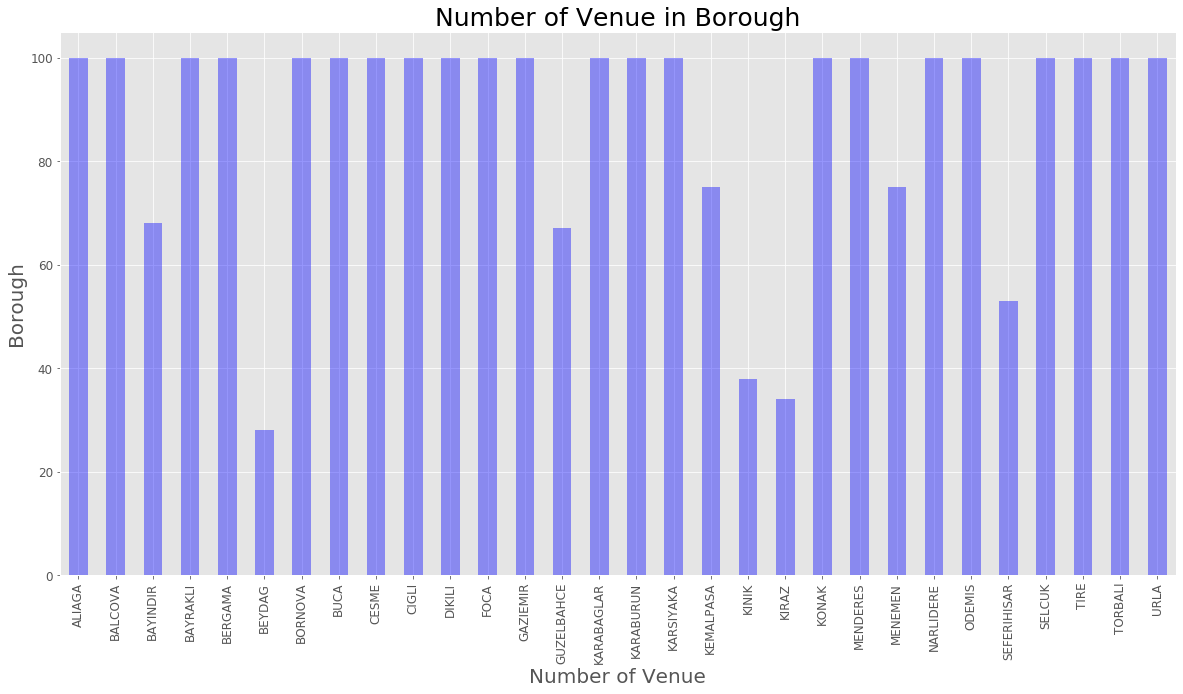

In [198]:
plt.style.use('ggplot')

izmir_venues.groupby('Borough')['Venue'].count().plot.bar(figsize=(20,10), color='blue', alpha=0.4, fontsize=12)

plt.title('Number of Venue in Borough', fontsize=25)
plt.ylabel('Borough', fontsize=20)
plt.xlabel('Number of Venue', fontsize=20)

In [16]:
print('There are {} uniques categories.'.format(len(izmir_venues['Venue Category'].unique())))

There are 272 uniques categories.


Since I will use Kmeans to cluster boroughs I can't use the categorical datatype because of that I converted them to numerical datatype using one hot encoding and also calculated the mean of grouped venue categories for each of the boroughs.

In [17]:
# one hot encoding
izmir_onehot = pd.get_dummies(izmir_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
izmir_onehot['Borough'] = izmir_venues['Borough'] 

# move neighborhood column to the first column
fixed_columns = [izmir_onehot.columns[-1]] + list(izmir_onehot.columns[:-1])
izmir_onehot = izmir_onehot[fixed_columns]

# Grouping and calculating the mean
izmir_grouped = izmir_onehot.groupby('Borough').mean().reset_index()

Here is how it's looks like.

In [19]:
izmir_grouped.head()

,Borough,ATM,Accessories Store,American Restaurant,Amphitheater,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Bath House,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Belgian Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bistro,Boarding House,Bookstore,Border Crossing,Borek Place,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Bridal Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Camera Store,Campground,Canal Lock,Candy Store,Carpet Store,Castle,Cheese Shop,Chocolate Shop,Church,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Theater,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Country Dance Club,Coworking Space,Credit Union,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Dive Spot,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Entertainment Service,Event Service,Event Space,Factory,Fair,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Gourmet Shop,Gozleme Place,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hunting Supply,IT Services,Ice Cream Shop,Intersection,Italian Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Kofte Place,Kokoreç Restaurant,Kumpir Restaurant,Kumru Restaurant,Kuruyemişçi,Lake,Lighthouse,Liquor Store,Lounge,Mac & Cheese Joint,Manti Place,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Meyhane,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Mosque,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Night Market,Nightclub,Nudist Beach,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pide Place,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Public Art,RV Park,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Road,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Chalet,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Sporting Goods Shop,Sports Club,Stadium,Stationery Store,Steakhouse,Supermarket,Surf Spot,Söğüş Place,Tailor Shop,Tea Room,Temple,Tennis Court,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Track,Trail,Train Station,Tree,Turkish Coffeehouse,Turkish Home Cooking Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Volleyball Court,Water Park,Waterfront,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,ALIAGA,0.000000,0.00,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.02,0.000000,0.0,0.0,0.000000,0.0,0.02,0.00,0.060000,0.00,0.0,0.0,0.02,0.0,0.00,0.02,0.0,0.0,0.00,0.0,0.0,0.0,0.01,0.0,0.0,0.000000,0.01,0.0,0.0,0.000000,0.0,0.000000,0.02,0.00,0.0,0.0,0.0,0.0,0.170000,0.01,0.0,0.01,0.0,0.0,0.00,0.000000,0.0,0.0,0.00,0.00,0.0,0

Then I created the function to get the top venue categories in the borough. 

In [139]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Top 10 venues will be returned as output.

In [21]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

Getting the top 10 venue categories in the borough.

In [22]:
# create a new dataframe
borough_venues_sorted = pd.DataFrame(columns=columns)
borough_venues_sorted['Borough'] = izmir_grouped['Borough']

for ind in np.arange(izmir_grouped.shape[0]):
    borough_venues_sorted.iloc[ind, 1:] = return_most_common_venues(izmir_grouped.iloc[ind, :], num_top_venues)

borough_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALIAGA,Café,Restaurant,Bar,Seafood Restaurant,Gym / Fitness Center,Turkish Restaurant,Fast Food Restaurant,Park,Bagel Shop,Ice Cream Shop
1,BALCOVA,Clothing Store,Coffee Shop,Gym / Fitness Center,Café,Sporting Goods Shop,Dessert Shop,Burger Joint,Restaurant,Seafood Restaurant,Breakfast Spot
2,BAYINDIR,Restaurant,Café,Hotel,Mountain,Pizza Place,Turkish Restaurant,Bar,Botanical Garden,Auto Garage,Night Market
3,BAYRAKLI,Café,Bakery,Pide Place,Restaurant,Grocery Store,Turkish Restaurant,Plaza,Park,Nightclub,Gym
4,BERGAMA,Café,Historic Site,Hotel,Turkish Restaurant,Bar,Lounge,Dessert Shop,Breakfast Spot,Food Court,Jewelry Store


I removed categorical column before creating model. I'll be using KMeans clustering machine learning algorithm to cluster similar boroughs. KMeans algorithm is one of the most common cluster method of unsupervised learning.

In [23]:
izmir_grouped_clustering = izmir_grouped.drop('Borough', 1)

First I used elbow method to find optimal cluster value.

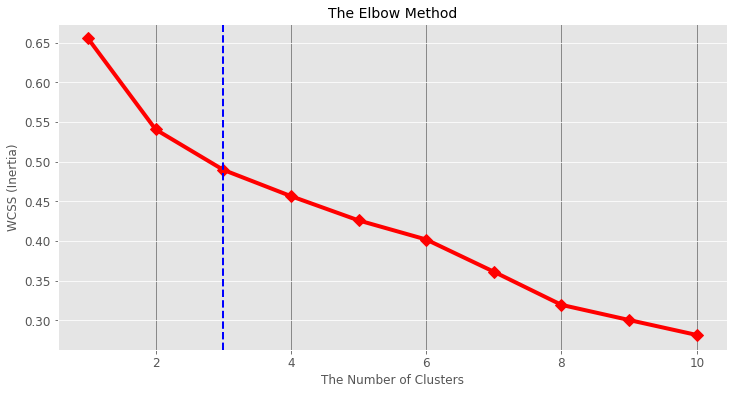

In [199]:
wscc = []

# Cluster value between 1-10 
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(izmir_grouped_clustering)
    wscc.append(kmeans.inertia_)
    
plt.figure(figsize=(12,6))
plt.plot(range(1,11), wscc, linewidth = 4, color = 'red', marker = 'D', markersize = 8)
plt.title('The Elbow Method', fontsize=14)
plt.xlabel('The Number of Clusters', fontsize=12)
plt.ylabel('WCSS (Inertia)', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize=12)
plt.grid(which = 'both', color = 'black', axis = 'x', alpha = 0.5)

# Optimal K (Clustering) value, defined after analyze
kclusters=3

plt.axvline(x = kclusters, linewidth = 2, color = 'blue', linestyle = '--')

I used silhouette score to validate our k value where I got it from elbow method.

<function matplotlib.pyplot.show(*args, **kw)>

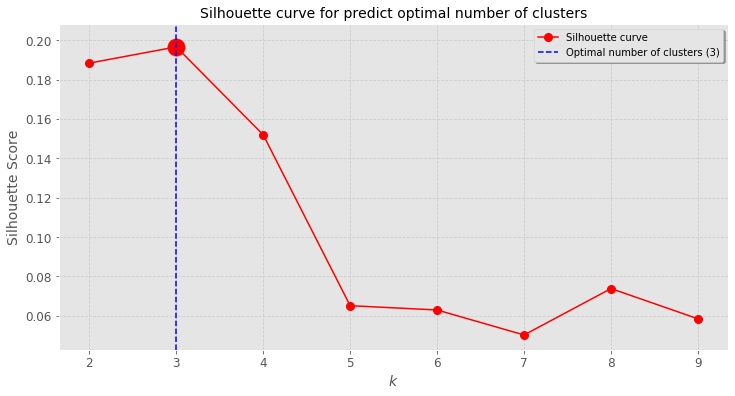

In [144]:
kmeans_per_k = [KMeans(n_clusters = k, random_state=0).fit(izmir_grouped_clustering) for k in range(1,10)]
silhouette_scores = [silhouette_score(izmir_grouped_clustering, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(12,6))
plt.plot(range(2,10), silhouette_scores, 'bo-', color = 'red', markersize=8, label = 'Silhouette curve')
plt.xlabel('$k$', fontsize=14); plt.ylabel('Silhouette Score', fontsize=14);
plt.xticks(fontsize = 12); plt.yticks(fontsize=12);
plt.grid(which='major', color = '#cccccc', linestyle='--')
plt.title('Silhouette curve for predict optimal number of clusters', fontsize=14)

k = np.argmax(silhouette_scores) + 2

plt.axvline(x=k, linestyle='--', c='blue', label = 'Optimal number of clusters ({})'.format(k))

plt.scatter(k, silhouette_scores[k-2], c='red', s=300)
plt.legend(shadow=True)
plt.show

I calculated optimal clustering value as 3 and created kmeans.

In [93]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(izmir_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1])

I added kmeans labels into dataframe.

In [95]:
borough_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

I used join method to merge dataframes.

In [96]:
izmir_merged = df_izmir
izmir_merged = izmir_merged.join(borough_venues_sorted.set_index('Borough'), on='Borough')

I created map using clustered boroughs.

In [155]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(izmir_merged['Latitude'], izmir_merged['Longitude'], izmir_merged['Borough'], izmir_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Cluster 0 Red: Accommodation & Seasonal

In [98]:
izmir_merged.loc[izmir_merged['Cluster Labels'] == 0, izmir_merged.columns[[0] + list(range(4, izmir_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,CESME,Hotel,Café,Bed & Breakfast,Seafood Restaurant,Ice Cream Shop,Pub,Turkish Restaurant,Gym / Fitness Center,Kumru Restaurant,Restaurant
10,DIKILI,Beach,Café,Bar,Turkish Restaurant,Hotel,Seafood Restaurant,Coffee Shop,Beach Bar,Ice Cream Shop,Park
11,FOCA,Hotel,Café,Beach,Bed & Breakfast,Harbor / Marina,Seafood Restaurant,Bar,Convenience Store,Coffee Shop,Grocery Store
15,KARABURUN,Hotel,Beach,Café,Seafood Restaurant,Bed & Breakfast,Restaurant,Dive Spot,Ice Cream Shop,Beach Bar,Motel
20,KONAK,Hotel,Dessert Shop,Turkish Restaurant,Coffee Shop,Historic Site,Söğüş Place,Café,Kofte Place,Motorcycle Shop,Turkish Home Cooking Restaurant
26,SELCUK,Hotel,Café,Coffee Shop,Turkish Restaurant,Restaurant,Fast Food Restaurant,Convenience Store,Park,Bed & Breakfast,Bar


Cluster 1 Purple: Mostly Cafes & Restaurant 

In [99]:
izmir_merged.loc[izmir_merged['Cluster Labels'] == 1, izmir_merged.columns[[0] + list(range(4, izmir_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALIAGA,Café,Restaurant,Bar,Seafood Restaurant,Gym / Fitness Center,Turkish Restaurant,Fast Food Restaurant,Park,Bagel Shop,Ice Cream Shop
1,BALCOVA,Clothing Store,Coffee Shop,Gym / Fitness Center,Café,Sporting Goods Shop,Dessert Shop,Burger Joint,Restaurant,Seafood Restaurant,Breakfast Spot
2,BAYINDIR,Restaurant,Café,Hotel,Mountain,Pizza Place,Turkish Restaurant,Bar,Botanical Garden,Auto Garage,Night Market
3,BAYRAKLI,Café,Bakery,Pide Place,Restaurant,Grocery Store,Turkish Restaurant,Plaza,Park,Nightclub,Gym
4,BERGAMA,Café,Historic Site,Hotel,Turkish Restaurant,Bar,Lounge,Dessert Shop,Breakfast Spot,Food Court,Jewelry Store
5,BEYDAG,Park,Café,Plaza,Food Court,History Museum,Bar,Convenience Store,Coffee Shop,Business Service,Bus Station
6,BORNOVA,Café,Dessert Shop,Coffee Shop,Gym / Fitness Center,Meyhane,Restaurant,Park,Turkish Restaurant,Hookah Bar,Art Gallery
7,BUCA,Café,Gym / Fitness Center,Coffee Shop,Bakery,Gym,Fast Food Restaurant,Turkish Restaurant,Restaurant,Sandwich Place,Soup Place
9,CIGLI,Café,Park,Restaurant,Turkish Restaurant,Bakery,Grocery Store,Gym / Fitness Center,Pide Place,Auto Garage,Shopping Mall
12,GAZIEMIR,Café,Turkish Restaurant,Coffee Shop,Bakery,Dessert Shop,Doner Restaurant,Arcade,Music Venue,Park,Gym / Fitness Center


Cluster 2: Big Box Store

In [100]:
izmir_merged.loc[izmir_merged['Cluster Labels'] == 2, izmir_merged.columns[[0] + list(range(4, izmir_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,KIRAZ,Big Box Store,Pharmacy,Fast Food Restaurant,Water Park,Steakhouse,Boarding House,Soccer Stadium,Soccer Field,Smoke Shop,Botanical Garden


Final look

In [197]:
final_df = izmir_merged.drop(['Latitude', 'Longitude'], axis = 1)
final_df.replace({'Cluster Labels' : { 0 : 'Accommodation & Seasonal', 1 : ' Mostly Cafes & Restaurant', 2 : 'Big Box Store' }}, inplace = True)
final_df

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALIAGA,Mostly Cafes & Restaurant,Café,Restaurant,Bar,Seafood Restaurant,Gym / Fitness Center,Turkish Restaurant,Fast Food Restaurant,Park,Bagel Shop,Ice Cream Shop
1,BALCOVA,Mostly Cafes & Restaurant,Clothing Store,Coffee Shop,Gym / Fitness Center,Café,Sporting Goods Shop,Dessert Shop,Burger Joint,Restaurant,Seafood Restaurant,Breakfast Spot
2,BAYINDIR,Mostly Cafes & Restaurant,Restaurant,Café,Hotel,Mountain,Pizza Place,Turkish Restaurant,Bar,Botanical Garden,Auto Garage,Night Market
3,BAYRAKLI,Mostly Cafes & Restaurant,Café,Bakery,Pide Place,Restaurant,Grocery Store,Turkish Restaurant,Plaza,Park,Nightclub,Gym
4,BERGAMA,Mostly Cafes & Restaurant,Café,Historic Site,Hotel,Turkish Restaurant,Bar,Lounge,Dessert Shop,Breakfast Spot,Food Court,Jewelry Store
5,BEYDAG,Mostly Cafes & Restaurant,Park,Café,Plaza,Food Court,History Museum,Bar,Convenience Store,Coffee Shop,Business Service,Bus Station
6,BORNOVA,Mostly Cafes & Restaurant,Café,Dessert Shop,Coffee Shop,Gym / Fitness Center,Meyhane,Restaurant,Park,Turkish Restaurant,Hookah Bar,Art Gallery
7,BUCA,Mostly Cafes & Restaurant,Café,Gym / Fitness Center,Coffee Shop,Bakery,Gym,Fast Food Restaurant,Turkish Restaurant,Restaurant,Sandwich Place,Soup Place
8,CESME,Accommodation & Seasonal,Hotel,Café,Bed & Breakfast,Seafood Restaurant,Ice Cream Shop,Pub,Turkish Restaurant,Gym / Fitness Center,Kumru Restaurant,Restaurant
9,CIGLI,Mostly Cafes & Restaurant,Café,Park,Restaurant,Turkish Restaurant,Bakery,Grocery Store,Gym / Fitness Center,Pide Place,Auto Garage,Shopping Mall


## 4. Results and Discussion

In this project, I focused on the most common venues in boroughs. In order to make an insightful data-driven decision. Ofcourse there are other factors can be used to get more accurate results like, neighborhood clustering, rent rate, annual househould income, population,  etc. for running a restaurant in Izmir. Unfortunately I couldn't find these datas for Izmir. First I decided to use neighborhoods in central Izmir but APIs like Nominatim or ArcGis didn't return latitude and longitude values correctly. I spent couple of days to figure it out and it always returned  incorrect values about couple of neighborhoods. For future research paid APIs like Google may perform better to get these values. Also I need to overcome API calls limitation from Foursquare and this means I need paid account for it. 


## 5. Conclusion

By looking at the cluster data, we can see that cluster 1 which is "Mostly Cafes & Restaurant" is the one that we are most interested in If stakeholder doesn't want to run a restaurant in seasonal places.

## 6. References

* [1] (https://wikitravel.org/en/Izmir)
* [2] (https://en.wikipedia.org/wiki/İzmir)
* [3] (https://data.humdata.org/dataset/ac768a5c-db29-4872-9792-bd3179e29c45/resource/f721e3c5-26e4-4750-b237-68ac1ac2c08b/download/common-operational-dataset.xlsx)
* [4] (https://geopy.readthedocs.io/en/stable/)  
* [5] (https://developer.foursquare.com/docs/places-api/)
